In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science','notebook'])

# Aula 04 - Interação de Lennard-Jones e Condição de Contorno Periódica

## Posições das Partículas em 2D

Vamos considerar 36 partículas colocados em uma caixa 2D com densidade de partículas $\rho \sigma^2 = N/V = 0.2$ onde $\sigma$ é o tamanho das partículas.

Número de átomos

In [2]:
Nparticles = 36

Tamanho de cada partícula

**Ex:** Para Ar (argônio) temos
- $\sigma = 3,4\ \AA$

In [3]:
sigma = 3.4*np.ones(Nparticles) # em unidades atômicas

Densidade de partículas

In [4]:
rho = 0.2 # N/V

Tamanho da caixa em 2D

Calculado pela relação $\rho = N/L^2$ tal que $L_x = L_y = \sqrt{N/\rho}$

In [5]:
Lx = Ly = np.sqrt(Nparticles/rho)*sigma.max()

Lx, Ly

(45.61578674099571, 45.61578674099571)

Vamos colocar os átomos de forma uniforme ao longo da caixa usando a função `meshgrid`

In [6]:
# Número de pontos em x e y
Nx = int(np.sqrt(Nparticles))
Ny = int(np.sqrt(Nparticles))
# ou seja, Nx.Ny = Nparticles

# Espaçamento entre os átomos
dx = Lx/Nx
dy = Ly/Ny

# Posições possíveis em x e y
xarray = np.arange(0.5*dx,Lx,dx)
yarray = np.arange(0.5*dy,Ly,dy)

# Cria uma grid em 2D
X,Y = np.meshgrid(xarray,yarray,indexing='ij')

# Colocando as partículas em suas posições
x0 = X.flatten()
y0 = Y.flatten()

In [7]:
x0

array([ 3.80131556,  3.80131556,  3.80131556,  3.80131556,  3.80131556,
        3.80131556, 11.40394669, 11.40394669, 11.40394669, 11.40394669,
       11.40394669, 11.40394669, 19.00657781, 19.00657781, 19.00657781,
       19.00657781, 19.00657781, 19.00657781, 26.60920893, 26.60920893,
       26.60920893, 26.60920893, 26.60920893, 26.60920893, 34.21184006,
       34.21184006, 34.21184006, 34.21184006, 34.21184006, 34.21184006,
       41.81447118, 41.81447118, 41.81447118, 41.81447118, 41.81447118,
       41.81447118])

Text(0, 0.5, 'y')

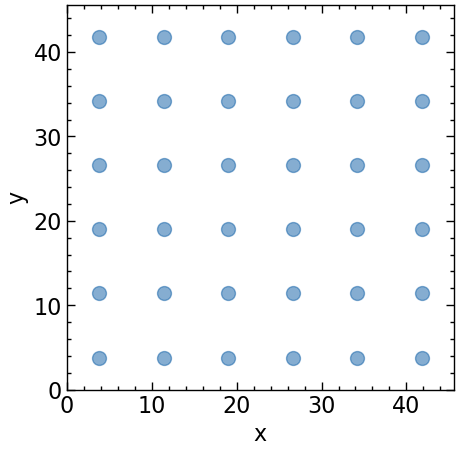

In [8]:
plt.figure(figsize=(5,5))
plt.plot(x0,y0,'o',ms=10.0,alpha=0.5)

plt.xlim(0,Lx)
plt.ylim(0,Ly)

plt.xlabel('x')
plt.ylabel('y')

## Velocidades das partículas

Da distribuição de Maxwell-Boltzmann sabemos que a distribuição de velocidades em cada direção deve ser uma gaussiana centrada em 0 e com variância associada à temperatura como dado ao longo de $x$

$$f(v_x) = \left(\frac{m}{2\pi k_B T}\right)^{1/2} \exp{\left(-\frac{m v_x^2}{2 k_B T}\right)}$$

e ao longo de $y$ 

$$f(v_y) = \left(\frac{m}{2\pi k_B T}\right)^{1/2} \exp{\left(-\frac{m v_y^2}{2 k_B T}\right)}$$

tal que a variância dessa gaussiana seja 

$$\sigma^2 = k_B T/m$$

**Vide Aula 03**

Vamos usar a função `np.random.normal` para sortear números aleatórios com uma dist gaussiana

In [9]:
# Parâmetros da função np.random.normal
# loc = média da gaussiana
# scale = desvio padrão = sqrt(variância)
# size = tamanho do array
kT = 150

v0x = np.random.normal(loc=0.0, scale=np.sqrt(kT),size=Nparticles)
v0y = np.random.normal(loc=0.0, scale=np.sqrt(kT),size=Nparticles)

In [10]:
v0x

array([ -0.66330436,  -3.01400672,   4.33487083,   9.88070572,
         8.06867941,  -8.89176814, -20.61666238, -16.13053509,
        11.50395764,  -7.98355421,  22.71938616, -18.23151272,
       -12.69330866,   5.1817846 ,  14.15712302,  17.87538183,
        13.10018877,   4.24375748, -30.65996317, -22.75131228,
       -12.22449415,  -6.7112626 ,  -3.71767414,   3.93488448,
        20.62454772,   9.22385451,   4.07790328, -10.75879045,
        -6.14540828,  -9.8613449 ,  11.31912276,  14.36615174,
        15.08866367, -11.98937295,   7.95344284,  23.37631818])

Text(0, 0.5, 'y')

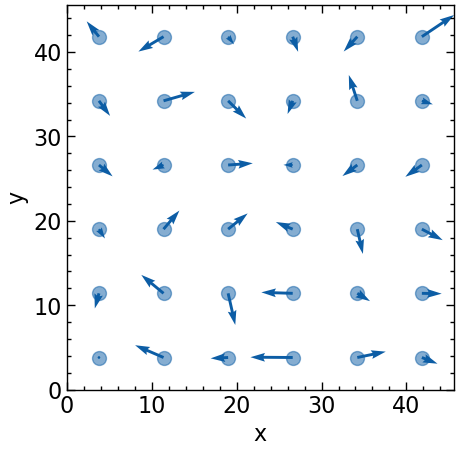

In [11]:
plt.figure(figsize=(5,5))
plt.plot(x0,y0,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(x0,y0,v0x,v0y,color='C0') # vetor de velocidade

plt.xlim(0,Lx)
plt.ylim(0,Ly)

plt.xlabel('x')
plt.ylabel('y')

Energia cinética $ K = \frac{m \boldsymbol{v}^2}{2}$

In [12]:
def energia_cinetica2d(vx,vy):
    return np.sum(0.5*(vx**2+vy**2))

In [13]:
K0 = energia_cinetica2d(v0x,v0y)

print(K0)

5085.273602021424


## Interação de Lennard-Jones

Para duas moléculas interagindo, podemos aproximar o potencial de interação a partir da interação de Lennard-Jones dada por 

$$u(r_{ij}) = 4\epsilon\left[ \left(\frac{\sigma}{r_{ij}} \right)^{12}-\left(\frac{\sigma}{r_{ij}} \right)^{6}\right] $$

com $\epsilon$ sendo uma energia de interação e $\sigma$ uma distância de aproximação mínima. 

**Ex:** Para Ar (argônio) temos
- $\epsilon/k_B = 119,8$ K


In [14]:
epsilon = 119.8*np.ones(Nparticles)

O potencial de LJ

In [15]:
def ulj(r,epsilon=1.0,sigma=1.0):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

(-1.0, 1.0)

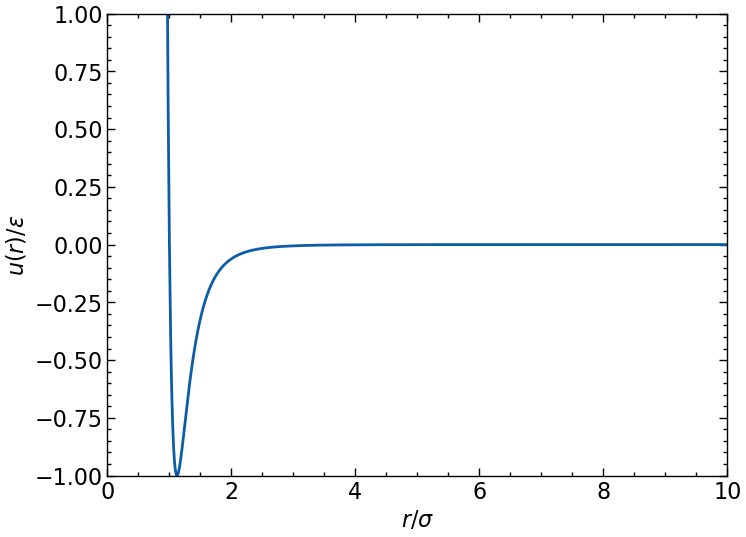

In [16]:
r = np.arange(0.1,10.0,0.01)

plt.plot(r,ulj(r))

plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$u(r)/\epsilon$')

plt.xlim(0,10.0)
plt.ylim(-1.0,1.0)

Podemos definir uma distãncia máxima `rcut` (um cutoff) tal que a interação de LJ seja nula a partir dela, ou seja, $ u(r) = 0$ se $ r> r_\text{cut}$.

In [17]:
rcut = 2.5

Derivada do potencial de LJ: $ \frac{\partial u(r)}{\partial r}$

In [18]:
def duljdr(r,epsilon=1.0,sigma=1.0):
    return -4*epsilon*((12*(sigma/r)**12-6*(sigma/r)**6)/r)

A energia interna do gás é dada pela soma de interação entre os pares
$$U_{int} = \frac{1}{2}\sum_i \sum_{j \neq i} u(|\boldsymbol{r}_i-\boldsymbol{r}_j|)= \sum_i \sum_{j > i} u(|\boldsymbol{r}_i-\boldsymbol{r}_j|)$$

Vamos calcular a força total que atua sobre a partícula $i$ a partir do gradiente da energia potencial 

$$ \boldsymbol{F}_i = - \nabla_i U_{int} = - \frac{1}{2}\sum_{k} \sum_{j \neq k} \frac{\partial u(r_{kj})}{\partial r_{kj}} \frac{\partial r_{kj}}{\partial \boldsymbol{r}_i}=-\frac{1}{2}\sum_{k} \sum_{j \neq k} \frac{\partial u(r_{kj})}{\partial r_{kj}} \frac{(\delta_{ki}-\delta_{ij})(\boldsymbol{r}_k -\boldsymbol{r}_j)}{ |\boldsymbol{r}_k-\boldsymbol{r}_j|}$$

de modo que 

$$ \boldsymbol{F}_i = -\sum_{j \neq i} \frac{\partial u(r_{ij})}{\partial r_{ij}} \frac{\boldsymbol{r}_{ij}}{ \boldsymbol{r}_{ij}}$$

com $\boldsymbol{r}_{ij} = \boldsymbol{r}_{i} - \boldsymbol{r}_{j}$ sendo o vetor posição relativa da partícula $i$ vista da partícula $j$. 

Definindo a função que calcula a aceleração de cada partícula e a energia interna do sistema

In [19]:
def lennardjones2d(x,y,epsilon,sigma):
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    U = 0.0
    for i in range(Nparticles):
        for j in range(i+1,Nparticles):
            # calcula distancia entre duas particulas
            rx = x[i] - x[j]
            ry = y[i] - y[j]
            # calcula modulo da distancia 
            r = np.sqrt(rx**2 + ry**2)
            # regra de combinação de Lorenz-Berthelot
            epsilonij = np.sqrt(epsilon[i]*epsilon[j])
            sigmaij = 0.5*(sigma[i]+sigma[j])
            # Vamos considerar somente interação dentro do raio de corte
            if r < rcut*sigmaij:
                # calcula a derivada do potencial 
                dudr = duljdr(r,epsilonij,sigmaij)
                # calcula aceleração na particula i 
                ax[i] += -dudr*rx/r
                ay[i] += -dudr*ry/r
                # calcula aceleração na particula j usando 3ª Lei de Newton 
                ax[j] += dudr*rx/r
                ay[j] += dudr*ry/r
                # calcula energia interna
                U += ulj(r,epsilonij,sigmaij)
    return ax, ay, U

Considerando os parâmetros do potencial de LJ e calculando a aceleração inicial

In [20]:
a0x, a0y, U0 = lennardjones2d(x0,y0,epsilon,sigma)

print(U0)

-228.17587200000017


In [21]:
U0 + K0

4857.0977300214245

Text(0, 0.5, 'y')

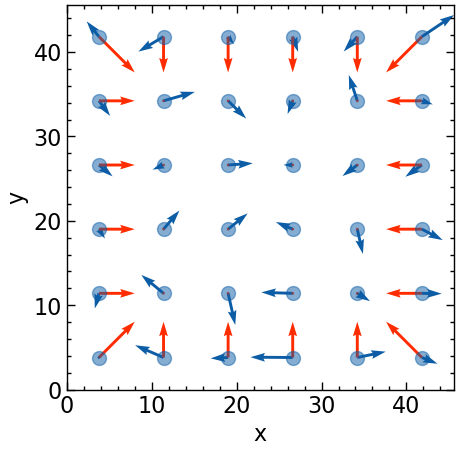

In [22]:
plt.figure(figsize=(5,5))
plt.plot(x0,y0,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(x0,y0,v0x,v0y,color='C0') # vetor de velocidade
plt.quiver(x0,y0,a0x,a0y,color='C3') # vetor de aceleração

plt.xlim(0,Lx)
plt.ylim(0,Ly)

plt.xlabel('x')
plt.ylabel('y')

## Condição de Contorno Períodica

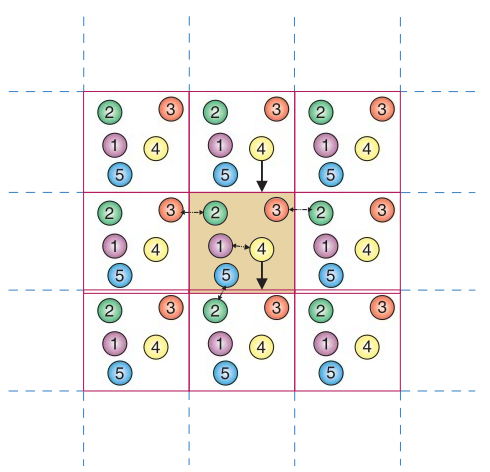

- Se x<0 faremos $ x = x + L$

- Se x>L faremos $ x = x- L$

In [23]:
def pbc(x,L):
    if x < 0:
        xnew = x + L
    elif x > L: 
        xnew = x - L
    else:
        xnew = x  
    return xnew

In [24]:
pbc(50.0,Lx) # fora da caixa pela direita

4.384213259004291

In [25]:
pbc(-10.0,Lx) # fora da caixa pela esquerda

35.61578674099571

In [26]:
pbc(10.0,Lx) # dentro da caixa

10.0

A função `%` faz o mesmo trabalho

In [27]:
50.0 % Lx # fora da caixa pela direita

4.384213259004291

In [28]:
-10.0 % Lx # fora da caixa pela esquerda

35.61578674099571

In [29]:
10.0 % Lx  # dentro da caixa

10.0

Incluindo condição de contorno periódica na interação de lennard-jones

In [30]:
def lennardjones2d_periodica(x,y,epsilon,sigma):
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    U = 0.0
    for i in range(Nparticles):
        for j in range(i+1,Nparticles):
            # calcula distancia entre duas particulas
            rx = x[i] - x[j]
            ry = y[i] - y[j]
            # testa condição de contorno periodica
            rx = rx % Lx # em x
            ry = ry % Ly # em y
            # calcula modulo da distancia 
            r = np.sqrt(rx**2 + ry**2)
            # regra de combinação de Lorenz-Berthelot
            epsilonij = np.sqrt(epsilon[i]*epsilon[j])
            sigmaij = 0.5*(sigma[i]+sigma[j])
            # Vamos considerar somente interação dentro do raio de corte
            if r < rcut*sigmaij:
                # calcula a derivada do potencial 
                dudr = duljdr(r,epsilonij,sigmaij)
                # calcula aceleração na particula i 
                ax[i] += -dudr*rx/r
                ay[i] += -dudr*ry/r
                # calcula aceleração na particula j usando 3ª Lei de Newton 
                ax[j] += dudr*rx/r
                ay[j] += dudr*ry/r
                # calcula energia interna
                U += ulj(r,epsilonij,sigmaij)
    return ax, ay, U

In [31]:
a0x, a0y, U0 = lennardjones2d_periodica(x0,y0,epsilon,sigma)

print(U0)

-45.63517439999996


In [32]:
U0 + K0

5039.638427621424

## Generalizando para 3D

In [33]:
# Nparticles = 216
Nparticles = 1000

rho = 0.6

Vol = Nparticles/rho

Lx = Ly = Lz = np.power(Vol,1/3.0)*sigma.max()

sigma = 3.4*np.ones(Nparticles) 
epsilon = 119.8*np.ones(Nparticles)

In [34]:
# Número de pontos em x e y
Nx = int(np.round(np.power(Nparticles,1/3)))
Ny = int(np.round(np.power(Nparticles,1/3)))
Nz = int(np.round(np.power(Nparticles,1/3)))
# ou seja, Nx.Ny = Nparticles

# Espaçamento entre os átomos
dx = Lx/Nx
dy = Ly/Ny
dz = Lz/Nz

# Posições possíveis em x e y
xarray = np.arange(0.5*dx,Lx,dx)
yarray = np.arange(0.5*dy,Ly,dy)
zarray = np.arange(0.5*dz,Lz,dz)

# Cria uma grid em 3D
X,Y, Z = np.meshgrid(xarray,yarray,zarray,indexing='ij')

# Colocando as partículas em suas posições
x0 = X.flatten()
y0 = Y.flatten()
z0 = Z.flatten()

In [35]:
Nx

10

In [36]:
# scale = sigma
kT = 150

v0x = np.random.normal(loc=0.0, scale=np.sqrt(kT),size=Nparticles)
v0y = np.random.normal(loc=0.0, scale=np.sqrt(kT),size=Nparticles)
v0z = np.random.normal(loc=0.0, scale=np.sqrt(kT),size=Nparticles)

def energia_cinetica3d(vx,vy,vz):
    return np.sum(0.5*(vx**2+vy**2+vz**2))

K0 = energia_cinetica3d(v0x,v0y,v0z)

In [37]:
def lennardjones3d_periodica(x,y,z,epsilon,sigma):
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    az = np.zeros_like(z)
    U = 0.0
    for i in range(Nparticles):
        for j in range(i+1,Nparticles):
            # calcula distancia entre duas particulas
            rx = x[i] - x[j]
            ry = y[i] - y[j]
            rz = z[i] - z[j]
            # testa condição de contorno periodica
            rx = rx % Lx # em x
            ry = ry % Ly # em y
            rz = rz % Lz # em y
            # calcula modulo da distancia 
            r = np.sqrt(rx**2 + ry**2 + rz**2)
            # regra de combinação de Lorenz-Berthelot
            epsilonij = np.sqrt(epsilon[i]*epsilon[j])
            sigmaij = 0.5*(sigma[i]+sigma[j])
            # Vamos considerar somente interação dentro do raio de corte
            if r < rcut*sigmaij:
                # calcula a derivada do potencial 
                dudr = duljdr(r,epsilonij,sigmaij)
                # calcula aceleração na particula i 
                ax[i] += -dudr*rx/r
                ay[i] += -dudr*ry/r
                az[i] += -dudr*rz/r
                # calcula aceleração na particula j usando 3ª Lei de Newton 
                ax[j] += dudr*rx/r
                ay[j] += dudr*ry/r
                az[j] += dudr*rz/r
                # calcula energia interna
                U += ulj(r,epsilonij,sigmaij)
    return ax, ay, az, U

In [38]:
a0x, a0y, a0z, U0 = lennardjones3d_periodica(x0,y0,z0,epsilon,sigma)

In [39]:
K0, U0, K0+U0

(226282.18600569933, -41539.006909722244, 184743.1790959771)